In [1]:
import matplotlib.pyplot as plt
import pvlib

In [2]:
lat, lon = 40.4, -3.7

data_pvgis = pvlib.iotools.get_pvgis_tmy(lat, lon)

data_tmy = data_pvgis[0].rename(columns={
    'Gb(n)': 'dni',
    'G(h)': 'ghi',
    'Gd(h)': 'dhi',
    'T2m': 'temp_air',
    'WS10m': 'wind_speed',
})

data_tmy = data_tmy.set_index(
    data_tmy.index.map(lambda t: t.replace(year=2010)))

data = data_tmy#['2010-06-01':'2010-06-01']

location = pvlib.location.Location(
    latitude=lat, longitude=lon, altitude=695, tz='utc')

solpos = location.get_solarposition(data.index)

In [3]:
# %% Parámetros
# R_sh_exp = 5.5, # exp. R paral VALOR_DEFECTO
# EgRef = 1.121, # VALOR_DEFECTO
# irrad_ref = 1000,
# temp_ref = 25

modulo = 'isofoton'

if modulo == 'ejemplo':
    # https://pvpmc.sandia.gov/PVLIB_Matlab_Help/html/pvl_calcparams_PVsyst_help.html
    pv_mod_params = {
        "alpha_sc": -0.002,# coef. temp. Isc
        "gamma_ref": 1.1,# "Datos básicos"
        "mu_gamma": -0.0003,# "Parámetros modelo"
        "I_L_ref": 5.5,# Isc
        "I_o_ref": 2.2e-9,# "Datos básicos"
        "R_sh_ref": 200, # R paral ref "Parámetros modelo"
        "R_sh_0": 8700,# R paral G=0 W/m2 "Parámetros modelo"
        "R_s": 0.33,# R serie "Parámetros modelo"
        "cells_in_series": 60,
    }
    
    A = 1.00  # m2
    
elif modulo == 'isofoton':
    # Isofoton_I110 - PVSyst
    pv_mod_params = {
        "alpha_sc": 2.3e-3,  # coef. temp. Isc
        "gamma_ref": 0.970,  # "Datos básicos"
        "mu_gamma": 0,  # "Parámetros modelo"
        "I_L_ref": 6.76,  # Isc
        "I_o_ref": 0.23e-9,  # "Datos básicos"
        "R_sh_ref": 200,  # R paral ref "Parámetros modelo"
        "R_sh_0": 800,  # R paral G=0 W/m2 "Parámetros modelo"
        "R_s": 0.248,  # R serie "Parámetros modelo"
        "cells_in_series": 36,
    }
    
    A = 0.85  # m2

# calcula Pmp STC
Pdc_stc = pvlib.pvsystem.singlediode(*pvlib.pvsystem.PVSystem(
    module_parameters=pv_mod_params
    ).calcparams_pvsyst(
    effective_irradiance=1000,
    temp_cell=25))['p_mp']

eff_a = Pdc_stc / (1000 * A)
print(f'Pdc_stc={Pdc_stc:.0f} W, eff_a={eff_a:.2%}')

temp_mod_params = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['pvsyst']['freestanding']
# print(temp_mod_params)

Pdc_stc=110 W, eff_a=12.93%


In [4]:
#%% Modelo PVSyst
pv_sys = pvlib.pvsystem.PVSystem(
    surface_tilt=37,
    surface_azimuth=180,
    # albedo=0.2,
    module_parameters=pv_mod_params,
    temperature_model_parameters=temp_mod_params,
    modules_per_string=1,
)

pv_irr = pv_sys.get_irradiance(
    solar_zenith=solpos['zenith'],
    solar_azimuth=solpos['azimuth'],
    ghi=data['ghi'],
    dhi=data['dhi'],
    dni=data['dni']
)

effective_irradiance = pv_irr['poa_global']
# effective_irradiance.plot();data.ghi.plot()

# AOI
# pv_aoi = pv_sys.get_aoi(
#     solar_zenith=solpos['zenith'],
#     solar_azimuth=solpos['azimuth'],
# )
# pv_aoi.plot()

pv_cell_temp = pv_sys.pvsyst_celltemp(
    poa_global=effective_irradiance,
    temp_air=data['temp_air'],
    wind_speed=data['wind_speed']
)

# MODELO TÉRMICO SANDIA
# temp_mod_params = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
# print(temp_mod_params)
# pv_cell_temp_sapm = pvlib.temperature.sapm_cell(
#     poa_global=pv_irr['poa_global'],
#     temp_air=data['temp_air'],
#     wind_speed=data['wind_speed'],
#     **temp_mod_params
# )

pv_diode_parameters = pv_sys.calcparams_pvsyst(
    effective_irradiance=effective_irradiance,
    temp_cell=pv_cell_temp,
)

pv_power = pv_sys.singlediode(*pv_diode_parameters)

In [5]:
Yr = effective_irradiance.sum() / 1000
Ya = pv_power['p_mp'].sum() / Pdc_stc

Lc = Yr - Ya

PR = Ya / Yr

print(f'PR={PR:.2}, Ya={Ya:.0f} kWh/kW, Yr={Yr:.0f} kWh/kW')

PR=0.93, Ya=1950 kWh/kW, Yr=2103 kWh/kW


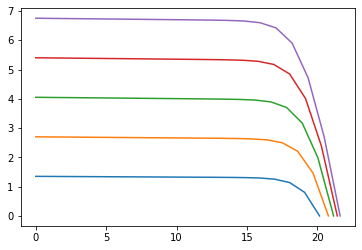

In [6]:
for G in [200, 400, 600, 800, 1000]:
    d = pv_sys.singlediode(*pv_sys.calcparams_pvsyst(
        effective_irradiance=G,
        temp_cell=25,
        ), ivcurve_pnts=20
        )
    plt.plot(d['v'], d['i'])


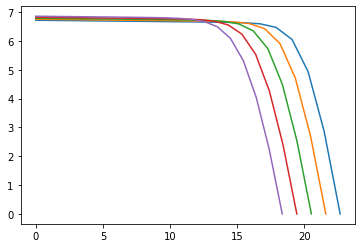

In [7]:
for t in [10, 25, 40, 55, 70]:
    d = pv_sys.singlediode(*pv_sys.calcparams_pvsyst(
        effective_irradiance=1000,
        temp_cell=t,
        ), ivcurve_pnts=20
        )
    plt.plot(d['v'], d['i'])

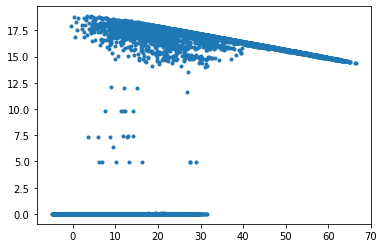

In [8]:
plt.plot(pv_cell_temp, pv_power['v_mp'], '.')